In [1]:
import numpy as np
from collections import deque, defaultdict
from copy import deepcopy

from PIL import Image
import imageio

import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
%matplotlib inline

from tol_colors import tol_cmap #https://personal.sron.nl/~pault/

In [2]:
with open('input_day10.txt', 'r') as f:
    data = f.readlines()
    f.close()

(43, 43)


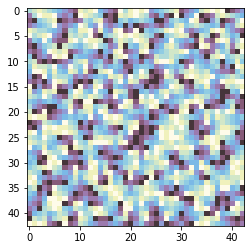

Part 1 result: 510


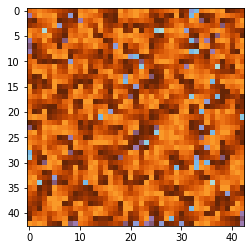

Part 2 result: 1058


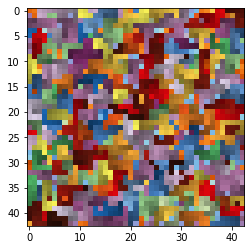

In [3]:
def get_graph(data):
    graph = []
    for line in data:
        line = line.strip()
        graph.append(list(line))
    graph = np.array(graph).astype(int)
    return graph

def in_graph(graph, pos):
    if pos[0] < 0 or pos[0] >= len(graph):
        return False
    if pos[1] < 0 or pos[1] >= len(graph[pos[0]]):
        return False
    return True

def BFS(graph, start):
    dxdy = [[-1,0],[0,1],[1,0],[0,-1]]
    queue = deque([start])
    
    dist = {start:0}
    score = 0
    
    while len(queue):
        cur_pos = queue.popleft()
        cur_val = graph[cur_pos[0]][cur_pos[1]]
        cur_dst = dist[cur_pos]
        
        for xy in dxdy:
            nxt_pos = (cur_pos[0]+xy[0], cur_pos[1]+xy[1])
            if in_graph(graph, nxt_pos) == False:
                continue
                
            nxt_val = graph[nxt_pos[0]][nxt_pos[1]]
            if nxt_val - cur_val != 1:
                continue
            
            nxt_dst = cur_dst+1
            if nxt_pos in dist.keys():
                if dist[nxt_pos] > nxt_dst:
                    dist[nxt_pos] = nxt_dst
            else:
                if nxt_val != 9:
                    queue.append(nxt_pos)
                else:
                    score += 1
                dist[nxt_pos] = nxt_dst
                
    return score, dist

def DFS(graph, cur_pos, ends, path):
    dxdy = [[-1,0],[0,1],[1,0],[0,-1]]
    
    cur_val = graph[cur_pos[0]][cur_pos[1]]
    
    for xy in dxdy:
        nxt_pos = (cur_pos[0]+xy[0], cur_pos[1]+xy[1])
        if in_graph(graph, nxt_pos):
            nxt_val = graph[nxt_pos[0]][nxt_pos[1]]
            if nxt_val - cur_val == 1:
                path.append(nxt_pos)
                if nxt_val == 9:
                    ends.append(path)
                else:
                    DFS(graph, nxt_pos, ends, deepcopy(path))
    return

def make_image(graph):
    image = np.ones((graph.shape[0],graph.shape[1],3))
    cmap = tol_cmap('iridescent')
    
    for i in range(0, len(graph)):
        for j in range(0, len(graph[i])):
            c = np.array(cmap((graph[i][j]/9.))[:3])*255
            image[i][j] = c
            
    plt.imshow(image.astype(int))
    return image

def save_frame(image, frame_num):
    frame = Image.fromarray(image.astype('uint8'), mode='RGB')
    frame = frame.resize((image.shape[0]*8,image.shape[1]*8), resample=Image.NEAREST)
    frame.save('./Day10-Frames/day10_'+str(frame_num).zfill(5)+'.png')

def flow_paths(graph, image, dist, frame_num):
    cmap = tol_cmap('YlOrBr')
    
    inv_dist = defaultdict(list)
    for pos, d in dist.items():
        inv_dist[d].append(pos)

    for i in range(0, 10):
        #c = np.array(cmap( 0.5+((1-(i/9.))*0.5)  )[:3])*255
        c = np.array(cmap( 0.5+((i/9.)*0.5) )[:3])*255
        #c = np.array(cmap( (i/9.) )[:3])*255
        
        for pos in inv_dist[i]:
            c = np.array(cmap( 0.5+(( graph[pos[0]][pos[1]] /9.)*0.5) )[:3])*255
            image[pos[0]][pos[1]] = c
        #plt.imshow(image.astype(int))
        #plt.show()
        
        frame_num += 1
        save_frame(image, frame_num)
        
            
    return image, frame_num

def draw_routes(graph, image, paths, frame_num, path_num):
    
    for path in paths:
        for i, pos in enumerate(path):
            
            #if frame_num%3 == 0:
            #    cmap = tol_cmap('PRGn')
            #    c = np.array(cmap( 0.5+(( graph[pos[0]][pos[1]] /9.)*0.5) )[:3])*255
            #elif frame_num%3 == 1:
            #    cmap = tol_cmap('PRGn')
            #    c = np.array(cmap( 0.5-(( graph[pos[0]][pos[1]] /9.)*0.5) )[:3])*255
            #else:
            #    cmap = tol_cmap('BuRd')
            #    c = np.array(cmap( 0.5-(( graph[pos[0]][pos[1]] /9.)*0.5) )[:3])*255
            
            cmap = tol_cmap('rainbow_discrete')
            idx = (path_num%28)/28.
            c = np.array(cmap(idx)[:3])*(255*( 1.0-(( graph[pos[0]][pos[1]] /9.)*0.5) ) )
            image[pos[0]][pos[1]] = c
            
            frame_num += 1
            save_frame(image, frame_num)
        path_num += 1
            
    return image, frame_num, path_num

def make_vis(data):
    graph = get_graph(data)
    print(graph.shape)
    image = make_image(graph)
    
    frame_num = 0
    save_frame(image, frame_num)
    
    plt.imshow(image.astype(int))
    plt.show()
    
    trailheads = np.where(graph == 0)
    
    total_score = 0
    for i in range(0, len(trailheads[0])):
        score, dist = BFS(graph, (trailheads[0][i], trailheads[1][i]))
        image, frame_num = flow_paths(graph, image, dist, frame_num)
        
        total_score += score
        
    print('Part 1 result:', total_score)
    plt.imshow(image.astype(int))
    plt.show()
    
    total_rating = 0
    path_num = 0
    for i in range(0, len(trailheads[0])):
        ends = []
        path = [(trailheads[0][i], trailheads[1][i])]
        DFS(graph, (trailheads[0][i], trailheads[1][i]), ends, deepcopy(path))
        image, frame_num, path_num = draw_routes(graph, image, ends, frame_num, path_num)
        
        total_rating += len(ends)
        
    print('Part 2 result:', total_rating)
    plt.imshow(image.astype(int))
    plt.show()
    
make_vis(data)